In [1]:
import os
import PIL
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# We define some parameters for our data and model:

TRAINING_DATA_DIR = "D:\MRI dataset\Training"
TEST_DATA_DIR = "D:\MRI dataset\Testing"
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180
EPOCHS=5

In [3]:
data_dir = pathlib.Path(TRAINING_DATA_DIR).with_suffix('')
test_data_dir = pathlib.Path(TEST_DATA_DIR).with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'There are {image_count} images in training dataset.')

There are 5712 images in training dataset.


In [4]:
list(data_dir.glob('*'))

[WindowsPath('D:/MRI dataset/Training/glioma'),
 WindowsPath('D:/MRI dataset/Training/meningioma'),
 WindowsPath('D:/MRI dataset/Training/notumor'),
 WindowsPath('D:/MRI dataset/Training/pituitary')]

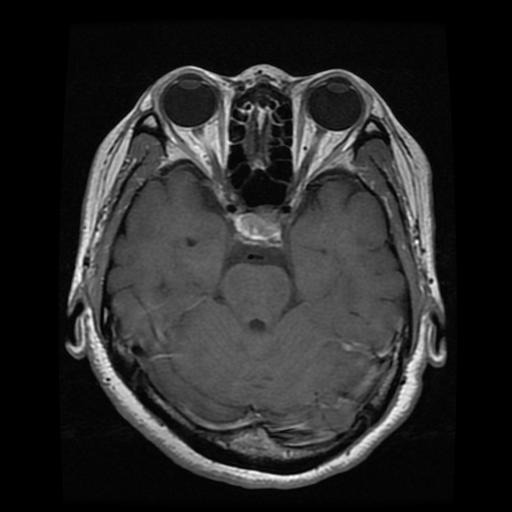

In [5]:
pituitary = list(data_dir.glob('pituitary/*'))
PIL.Image.open(str(pituitary[0]))

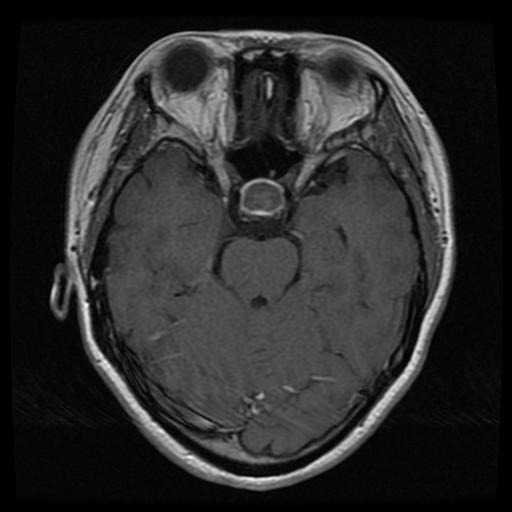

In [6]:
PIL.Image.open(str(pituitary[1]))

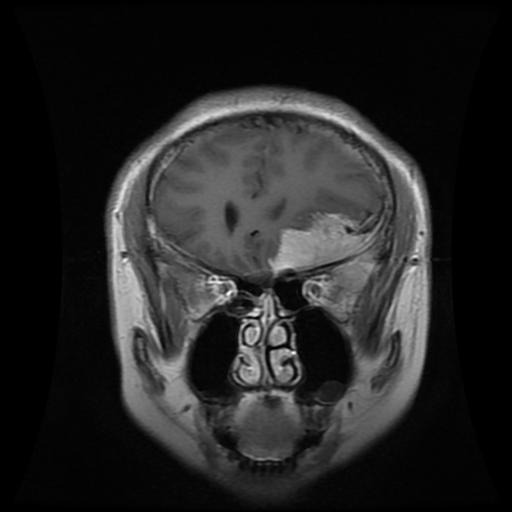

In [7]:
meningioma = list(data_dir.glob('meningioma/*'))
PIL.Image.open(str(meningioma[0]))

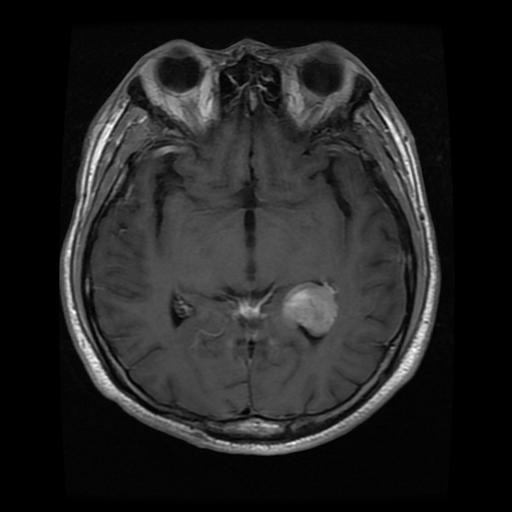

In [8]:
PIL.Image.open(str(meningioma[1]))

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [12]:
class_counts = {}

for images, labels in train_ds:
    for label in labels.numpy():
        class_name = class_names[label]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1

for class_name, count in class_counts.items():
    print(f"Number of images in class '{class_name}': {count}")
    
label_list = []

for _, labels in train_ds:
    label_list.extend(labels.numpy())

Number of images in class 'pituitary': 1164
Number of images in class 'meningioma': 1042
Number of images in class 'glioma': 1090
Number of images in class 'notumor': 1274


In [13]:
class_name_to_label = {class_name: idx for idx, class_name in enumerate(class_names)}
class_counts = {}

for _, labels in train_ds:
    for label in labels.numpy():
        class_name = class_names[label]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1

total_samples = len(label_list)

class_weights = {class_name_to_label[class_name]: total_samples / count for class_name, count in class_counts.items()}

sum_class_weights = sum(class_weights.values())
class_weights = {label: weight / sum_class_weights for label, weight in class_weights.items()}

print("Class Weights:")
print(class_weights)

Class Weights:
{3: 0.24398395271532267, 0: 0.2605480008813171, 2: 0.22291783434900753, 1: 0.27255021205435276}


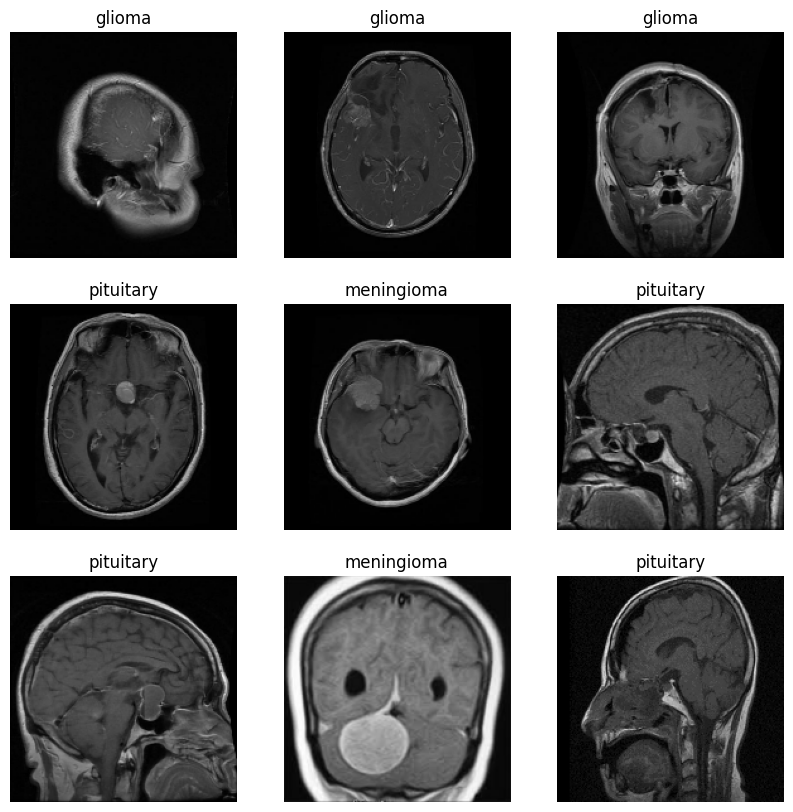

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

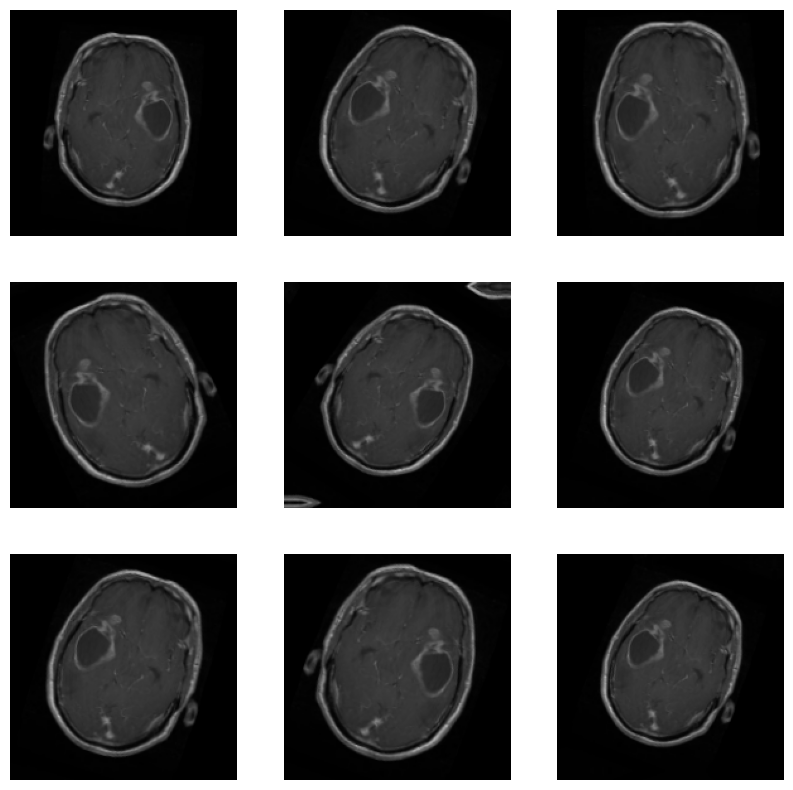

In [17]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [18]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.BatchNormalization(input_shape=(180, 180, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer='l2'), #kernel_regularizer=keras.regularizers.l2(l=0.1)
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4, activation='softmax')
])

# The model is compiled with the Adam optimizer, sparse categorical cross-entropy loss function (suitable for multi-class classification),
# and sparse categorical accuracy as the evaluation metric.

# Define custom precision and recall metrics
def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), precision, recall])

# Two callbacks are defined: EarlyStopping to stop training early if the validation loss does not improve after a certain number of epochs
# and ReduceLROnPlateau to reduce the learning rate when the validation loss plateaus.
              
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True)
lr_sch = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience= 8, factor = 0.1, verbose = 1, min_lr = 5e-10)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 batch_normalization (Batch  (None, 180, 180, 3)       12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 89, 89, 32)        128       
 chNormalization)                                                
                                                      

In [19]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    class_weight=class_weights,
                    callbacks=[early_stopping, lr_sch])

Epoch 1/5
143/143 [==============================] - 214s 1s/step - loss: 5.0095 - sparse_categorical_accuracy: 0.6678 - precision: 1.0699 - recall: 1.2108 - val_loss: 2.8736 - val_sparse_categorical_accuracy: 0.5044 - val_precision: 7.1295 - val_recall: 1.5947 - lr: 0.0010
Epoch 2/5
143/143 [==============================] - 205s 1s/step - loss: 1.2393 - sparse_categorical_accuracy: 0.7212 - precision: 1.0137 - recall: 1.1867 - val_loss: 1.8130 - val_sparse_categorical_accuracy: 0.5560 - val_precision: 2.0457 - val_recall: 1.5500 - lr: 0.0010
Epoch 3/5
143/143 [==============================] - 201s 1s/step - loss: 0.6747 - sparse_categorical_accuracy: 0.7422 - precision: 1.0200 - recall: 1.1900 - val_loss: 1.7260 - val_sparse_categorical_accuracy: 0.4694 - val_precision: 1.0869 - val_recall: 1.1557 - lr: 0.0010
Epoch 4/5
143/143 [==============================] - 199s 1s/step - loss: 0.5424 - sparse_categorical_accuracy: 0.7575 - precision: 0.9792 - recall: 1.1668 - val_loss: 1.0988 

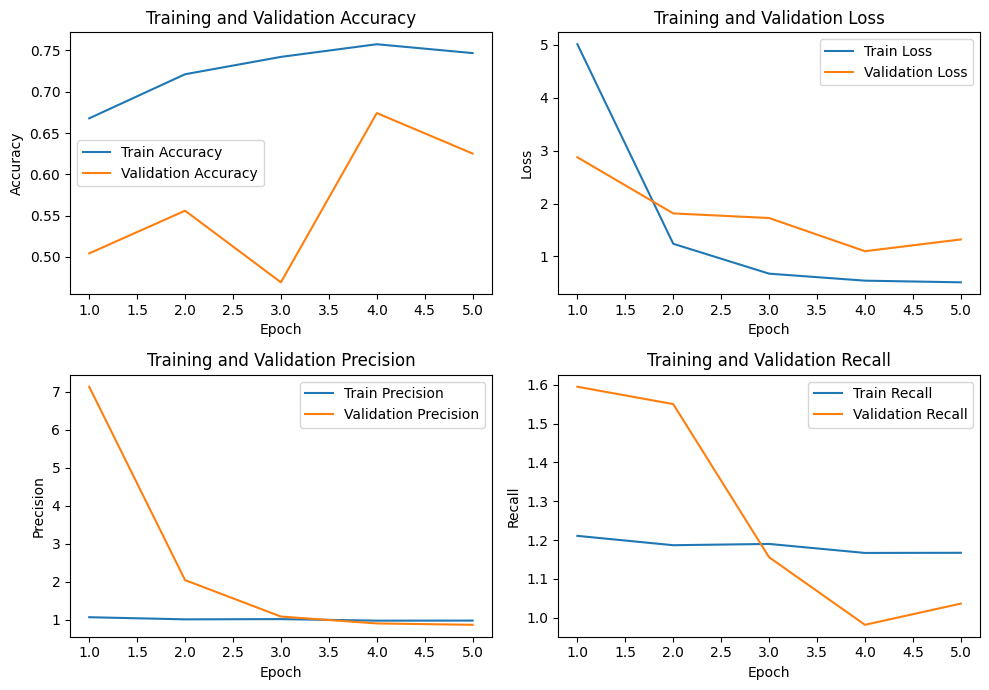

In [20]:
plt.figure(figsize=(10, 7))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(range(1, len(history.history['sparse_categorical_accuracy']) + 1), history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(range(1, len(history.history['val_sparse_categorical_accuracy']) + 1), history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(2, 2, 2)
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Train Loss')
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Precision
plt.subplot(2, 2, 3)
plt.plot(range(1, len(history.history['precision']) + 1), history.history['precision'], label='Train Precision')
plt.plot(range(1, len(history.history['val_precision']) + 1), history.history['val_precision'], label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')
plt.legend()

# Recall
plt.subplot(2, 2, 4)
plt.plot(range(1, len(history.history['recall']) + 1), history.history['recall'], label='Train Recall')
plt.plot(range(1, len(history.history['val_recall']) + 1), history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.legend()

plt.tight_layout()
plt.show()